# The generator status 4

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import uproot

from lcio_checks.mc.simulation import add_simulation_info
from lcio_checks.util import config, load_or_make


f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
mc = f.arrays(filter_name="mc*", entry_stop=-1)
add_simulation_info(mc)

x1 = mc[mc.mcgst == 4]
x2 = mc[(mc.mcgst == 3) & (mc.mcsst == -2147483648)]
assert all(ak.num(x1.mcori) == ak.num(x2.mcori))

Amongst those particles with generator status, some are created from overlay (files). They can be identifed by their simulation status `-2147483648`. The same particles are once again part of the Monte Carlo collection with generator status 4.
Here, we want to compair these two "copies" of the particle.
Additionally, we want to these what effect these particles have amongst those with generator status 3.

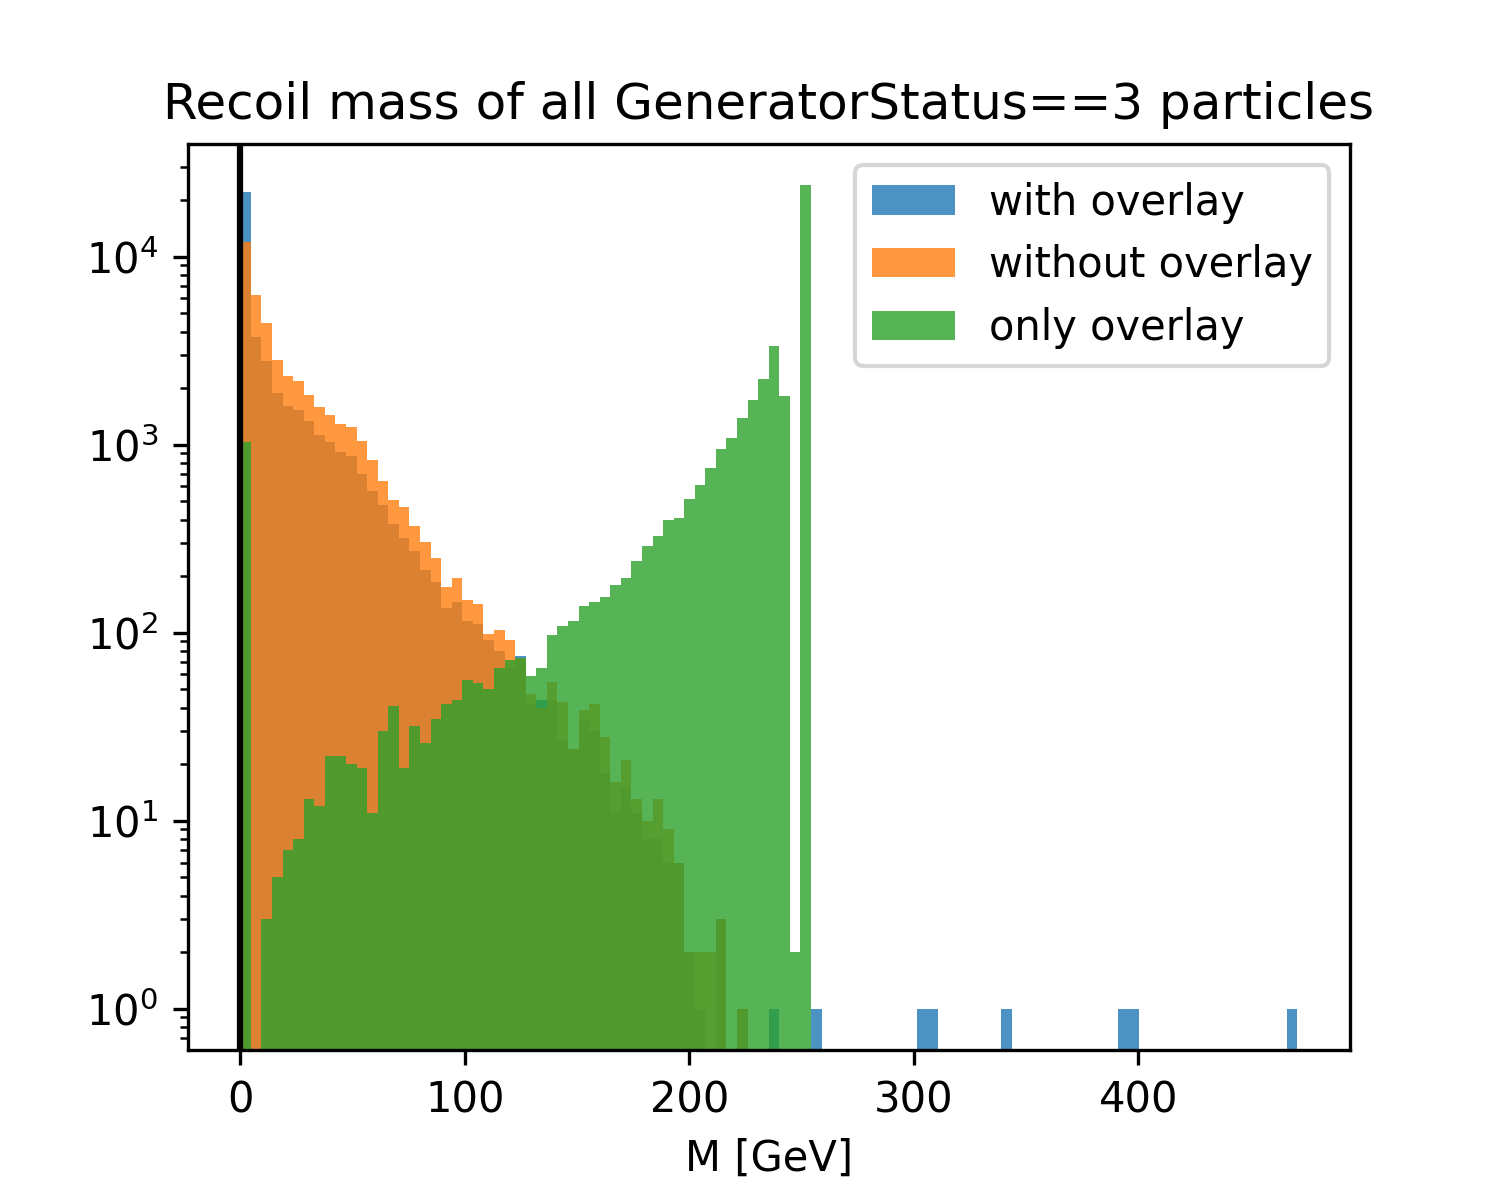

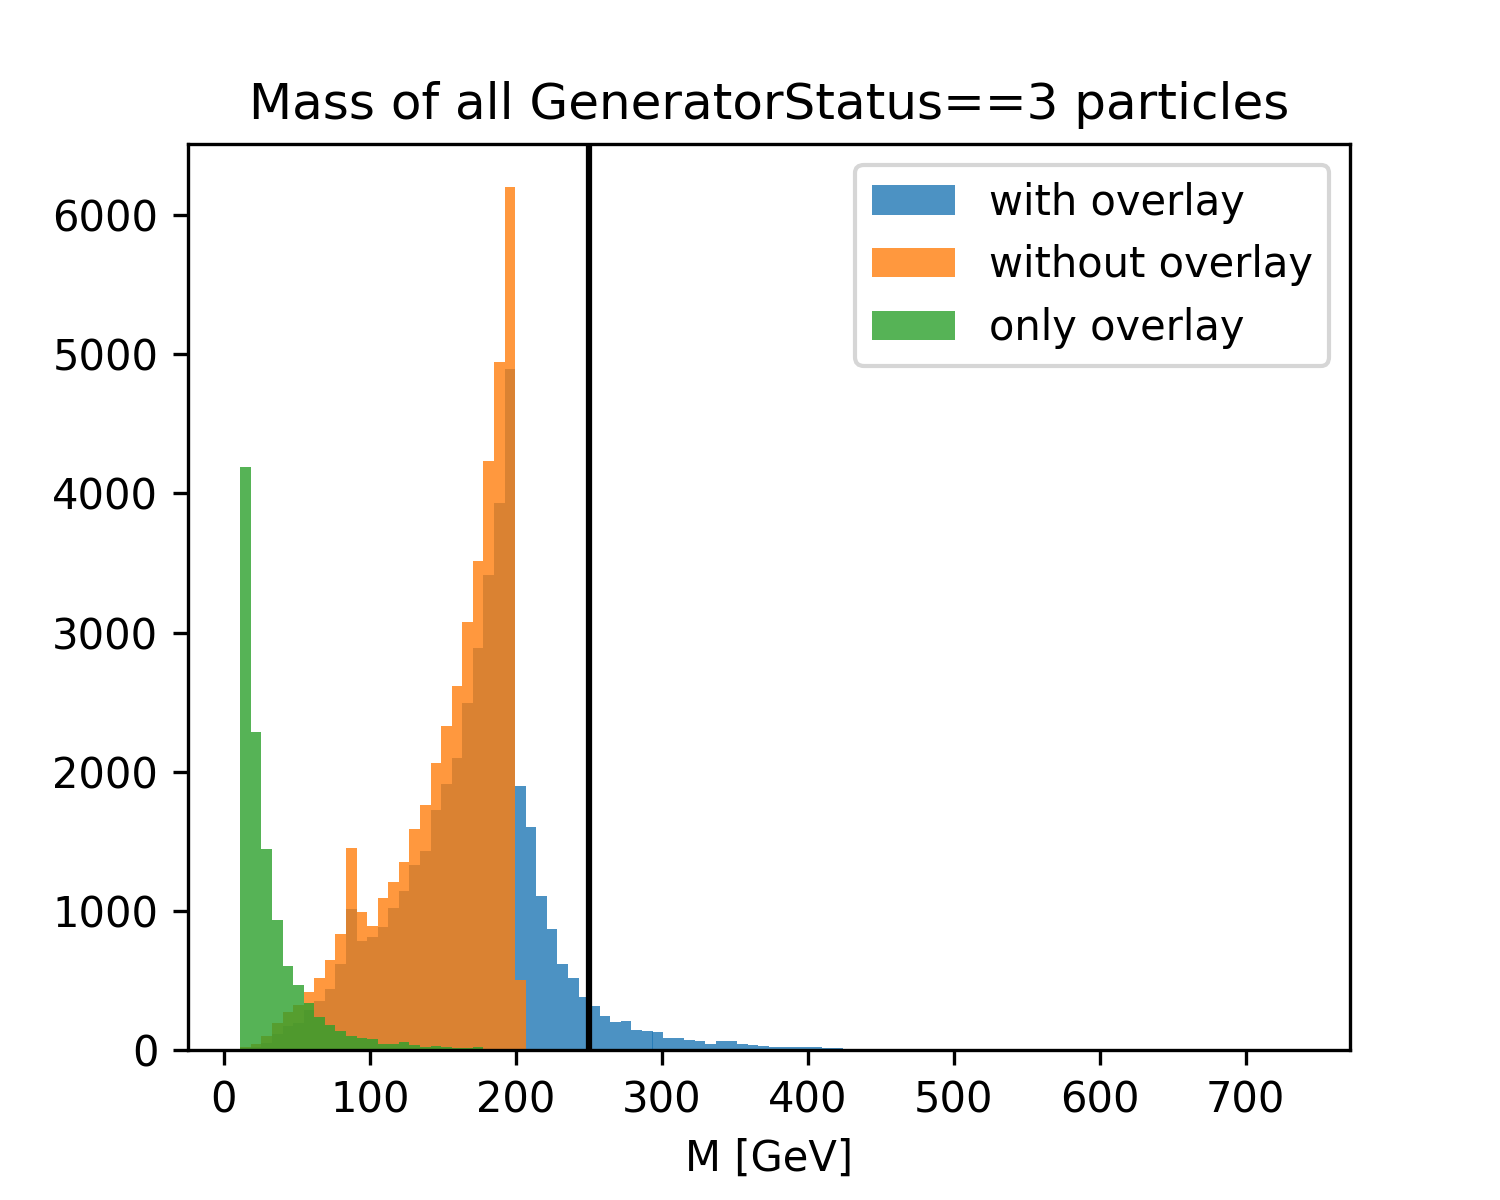

In [18]:
def pair_mass(x):
    return np.sqrt(
        ak.sum(x.mcene, axis=1) ** 2
        - ak.sum(x.mcmox, axis=1) ** 2
        - ak.sum(x.mcmoy, axis=1) ** 2
        - ak.sum(x.mcmoz, axis=1) ** 2
    )


def pair_recoil(x):
    var = (
        (250 - ak.sum(x.mcene, axis=1)) ** 2
        - ak.sum(x.mcmox, axis=1) ** 2
        - ak.sum(x.mcmoy, axis=1) ** 2
        - ak.sum(x.mcmoz, axis=1) ** 2
    )
    return np.sqrt(np.abs(var)) * (var > 0)


@load_or_make(["mc_recoil_mass"])
def mc_recoil_mass():
    assert len(np.unique(pair_recoil(x1))) == 1
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axvline(pair_recoil(x1)[0], color="black")
    bins = ax.hist(
        pair_recoil(mc[(mc.mcgst == 3)]),
        bins=100,
        label="with overlay",
        alpha=0.8,
    )[1]
    ax.hist(
        pair_recoil(x2),
        bins=bins,
        label="without overlay",
        alpha=0.8,
    )
    ax.hist(
        pair_recoil(mc[(mc.mcgst == 3) & (mc.mcsst != -2147483648)]),
        bins=bins,
        label="only overlay",
        alpha=0.8,
    )
    ax.legend()
    ax.set_xlabel("M [GeV]")
    ax.set_yscale("log")
    ax.set_title("Recoil mass of all GeneratorStatus==3 particles")
    return (fig,)


@load_or_make(["mc_pair_mass"])
def mc_pair_mass():
    assert len(np.unique(pair_mass(x1))) == 1
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axvline(pair_mass(x1)[0], color="black")
    bins = ax.hist(
        pair_mass(mc[(mc.mcgst == 3)]),
        bins=100,
        label="with overlay",
        alpha=0.8,
    )[1]
    ax.hist(
        pair_mass(x2),
        bins=bins,
        label="without overlay",
        alpha=0.8,
    )
    ax.hist(
        pair_mass(mc[(mc.mcgst == 3) & (mc.mcsst != -2147483648)]),
        bins=bins,
        label="only overlay",
        alpha=0.8,
    )
    ax.legend()
    ax.set_xlabel("M [GeV]")
    ax.set_title("Mass of all GeneratorStatus==3 particles")
    return (fig,)


mc_recoil_mass()
mc_pair_mass();

## Comparing the copies

First, let's look into which fields are equal or different between the two instances of a particle.

In [3]:
assert all(ak.num(x1.mcori) == ak.num(x2.mcori))
all_equal = []
not_all_equal = []
for f in x1.fields:
    if all(ak.flatten(x1[f] == x2[f])):
        all_equal.append(f)
    else:
        not_all_equal.append(f)

print("Fields where all values are equal:")
print(f"  {', '.join(all_equal)}")
print("\nFields with differences:")
print(f"  {', '.join(not_all_equal)}")

Fields where all values are equal:
  mcori, mcpdg, mcsst, mcvtx, mcvty, mcvtz, mcepx, mcepy, mcepz, mccha, mctim, mcspx, mcspy, mcspz, mccf0, mccf1, mcpa1, mcda2, mcda3, mcda4, isCreatedInSimulation, isBackscatter, vertexIsNotEndpointOfParent, isDecayedInTracker, isDecayedInCalorimeter, hasLeftDetector, isStopped, isOverlay

Fields with differences:
  mcgst, mcmox, mcmoy, mcmoz, mcmas, mcene, mcpa0, mcda0, mcda1


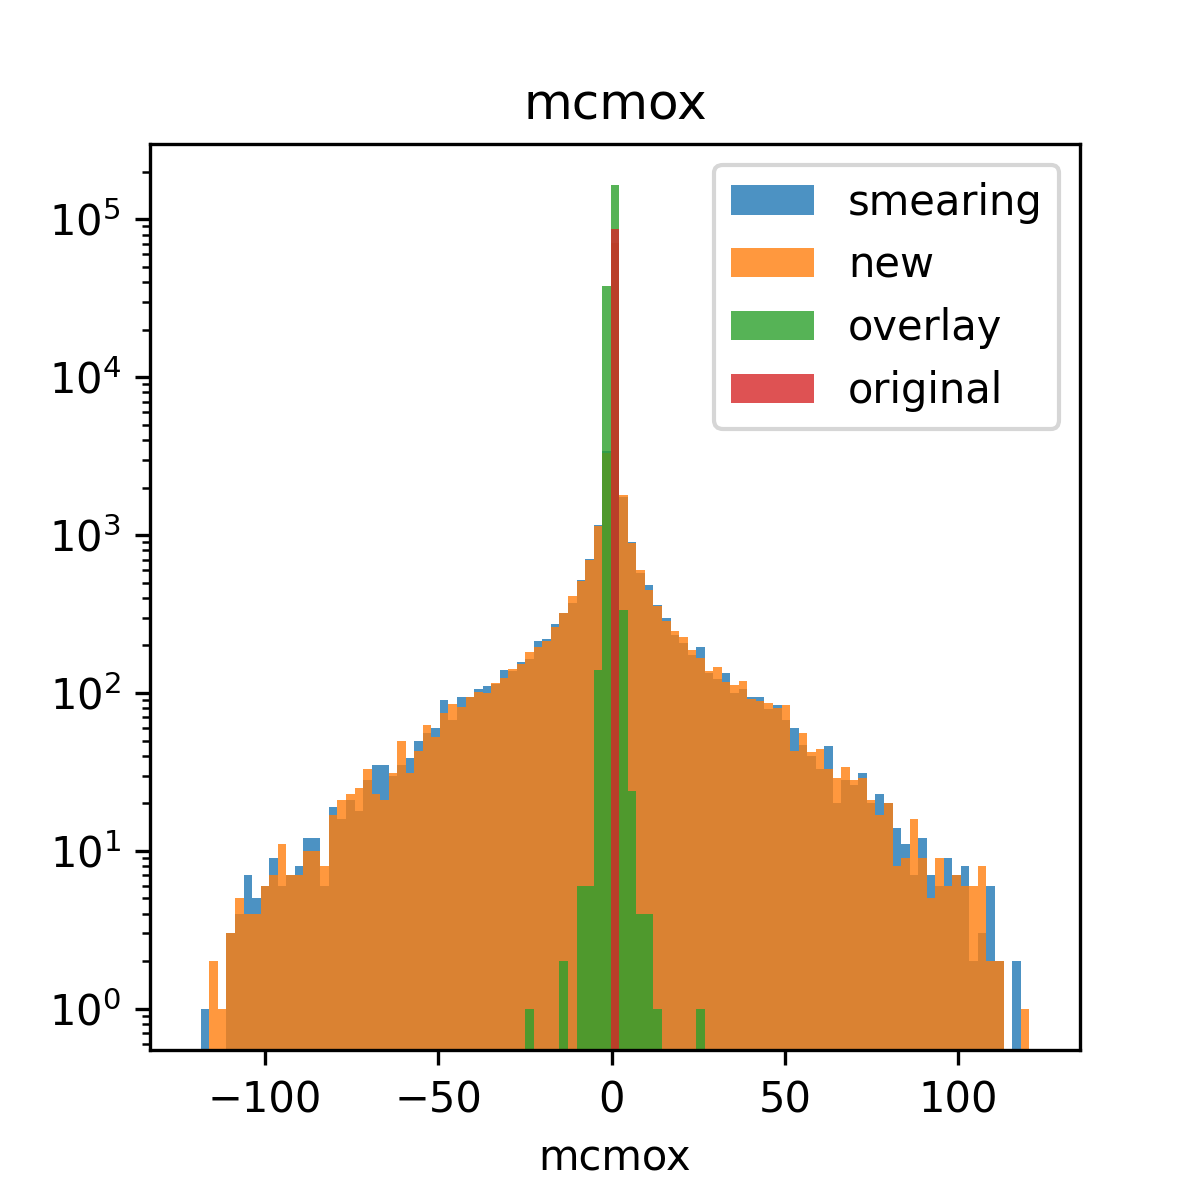

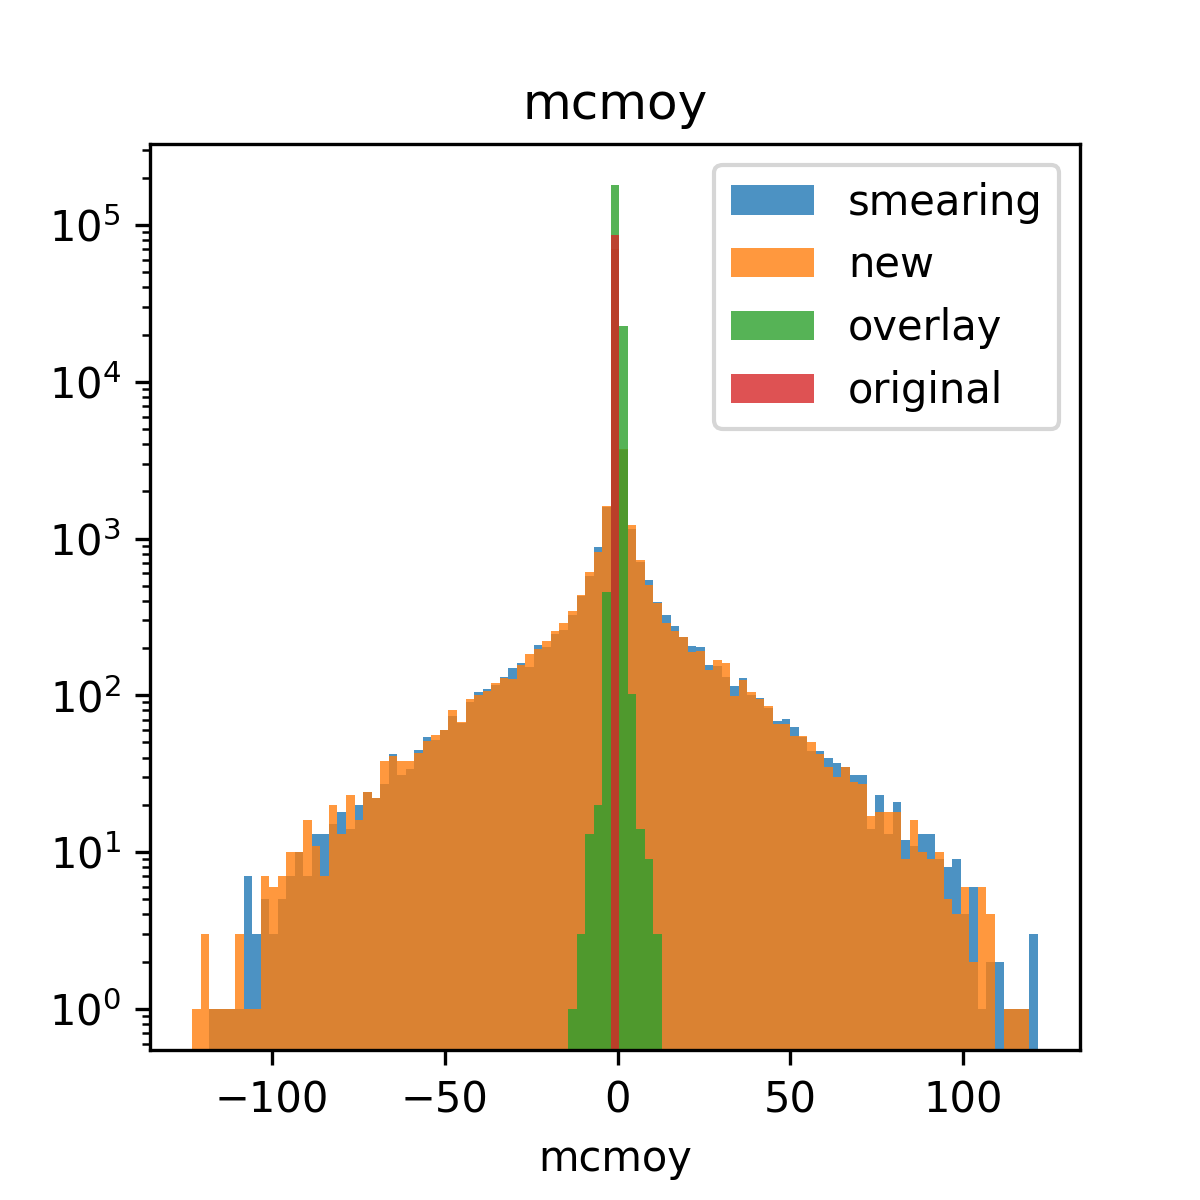

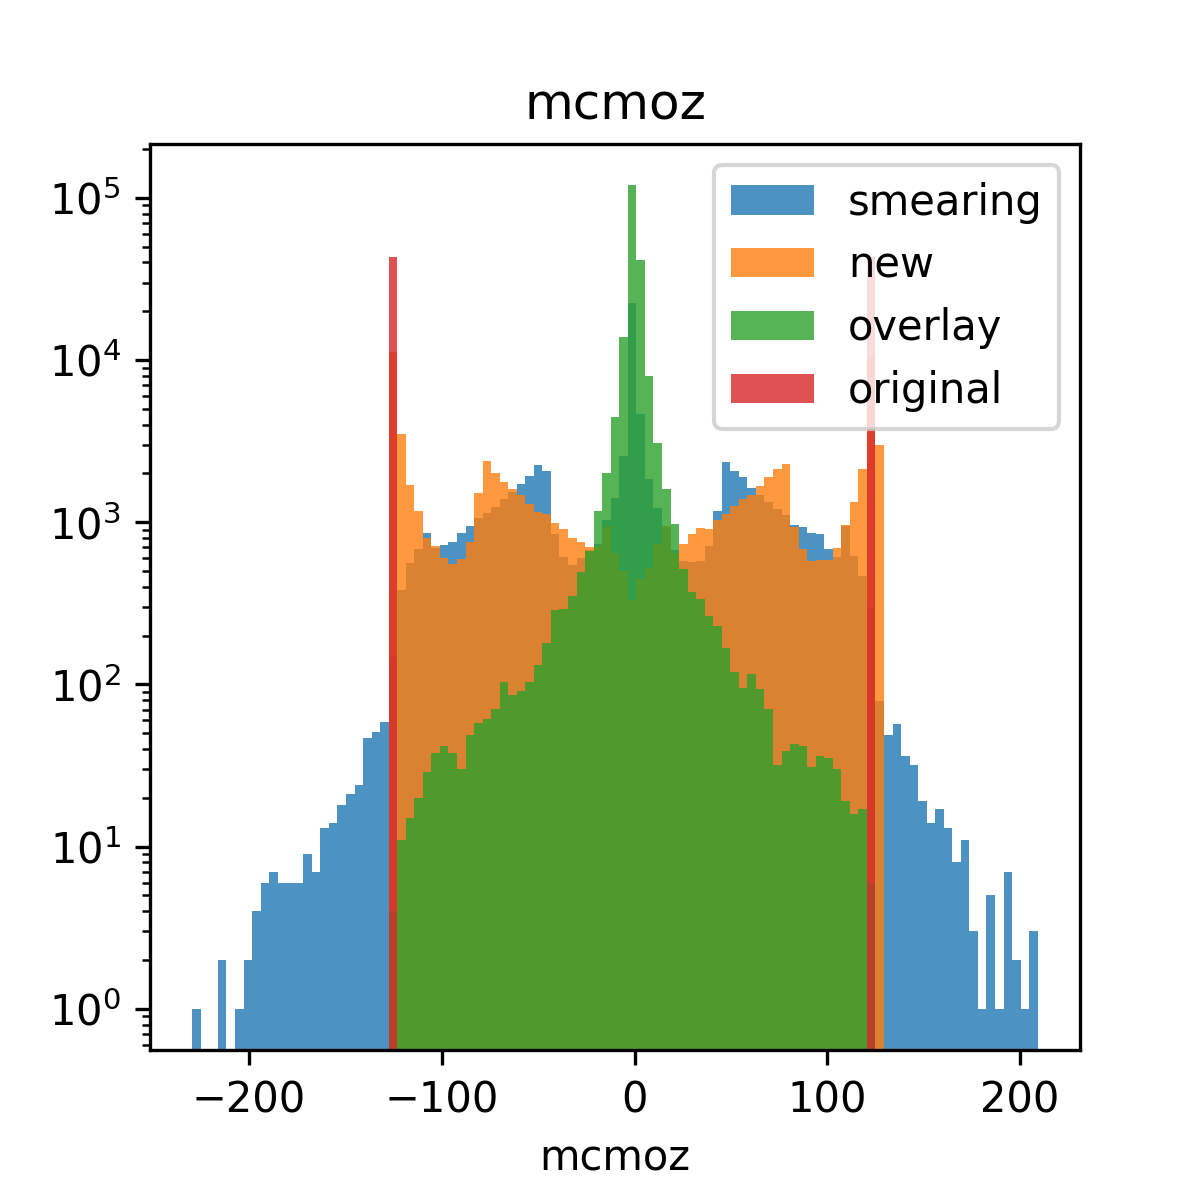

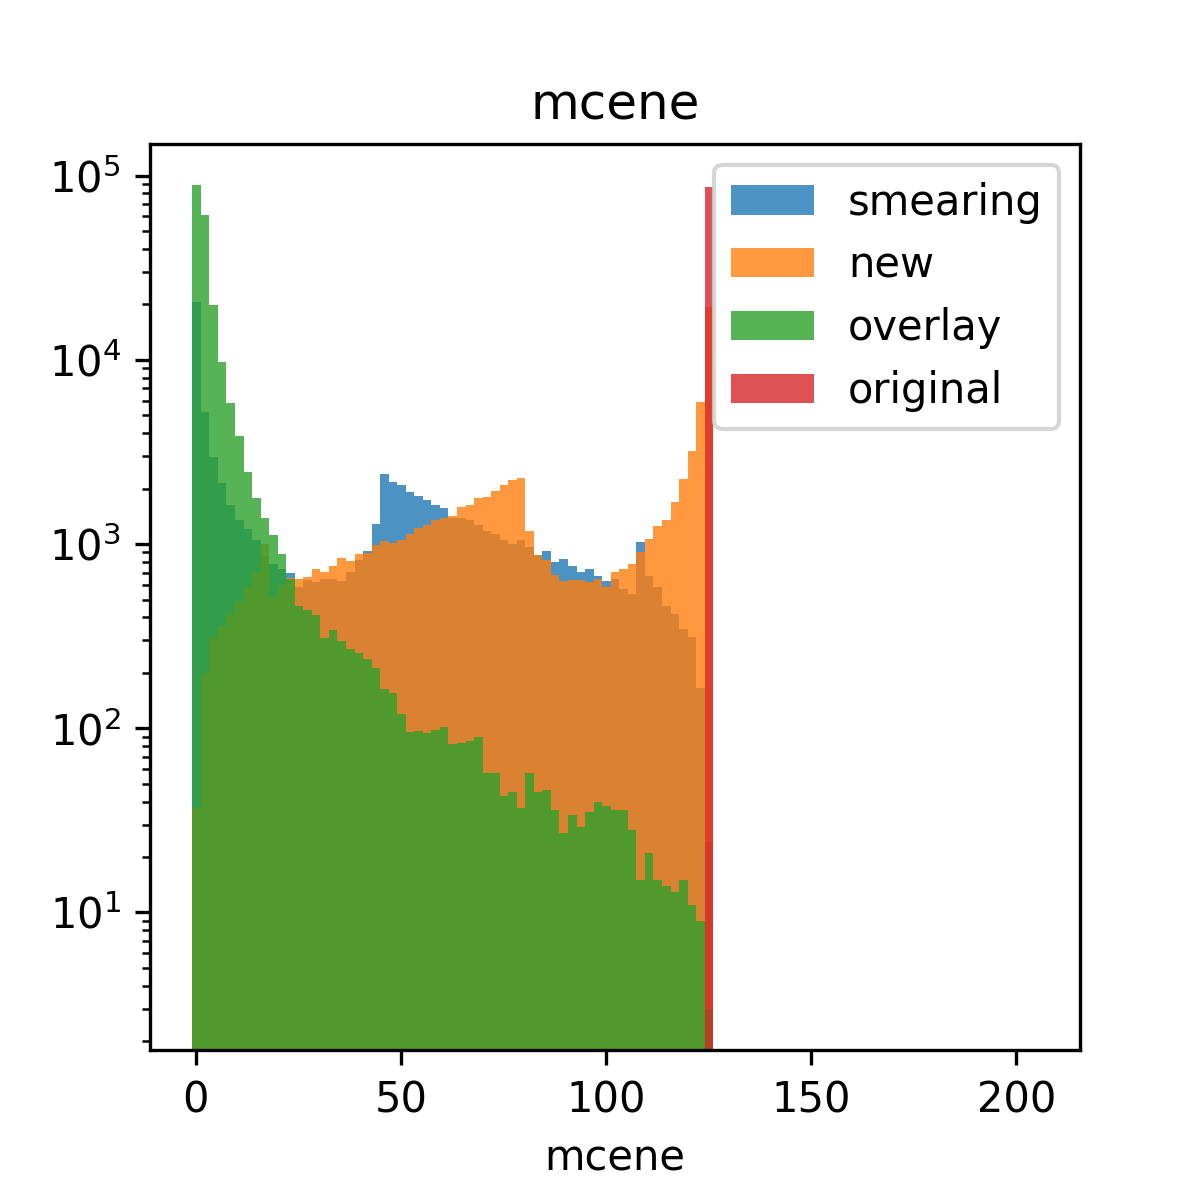

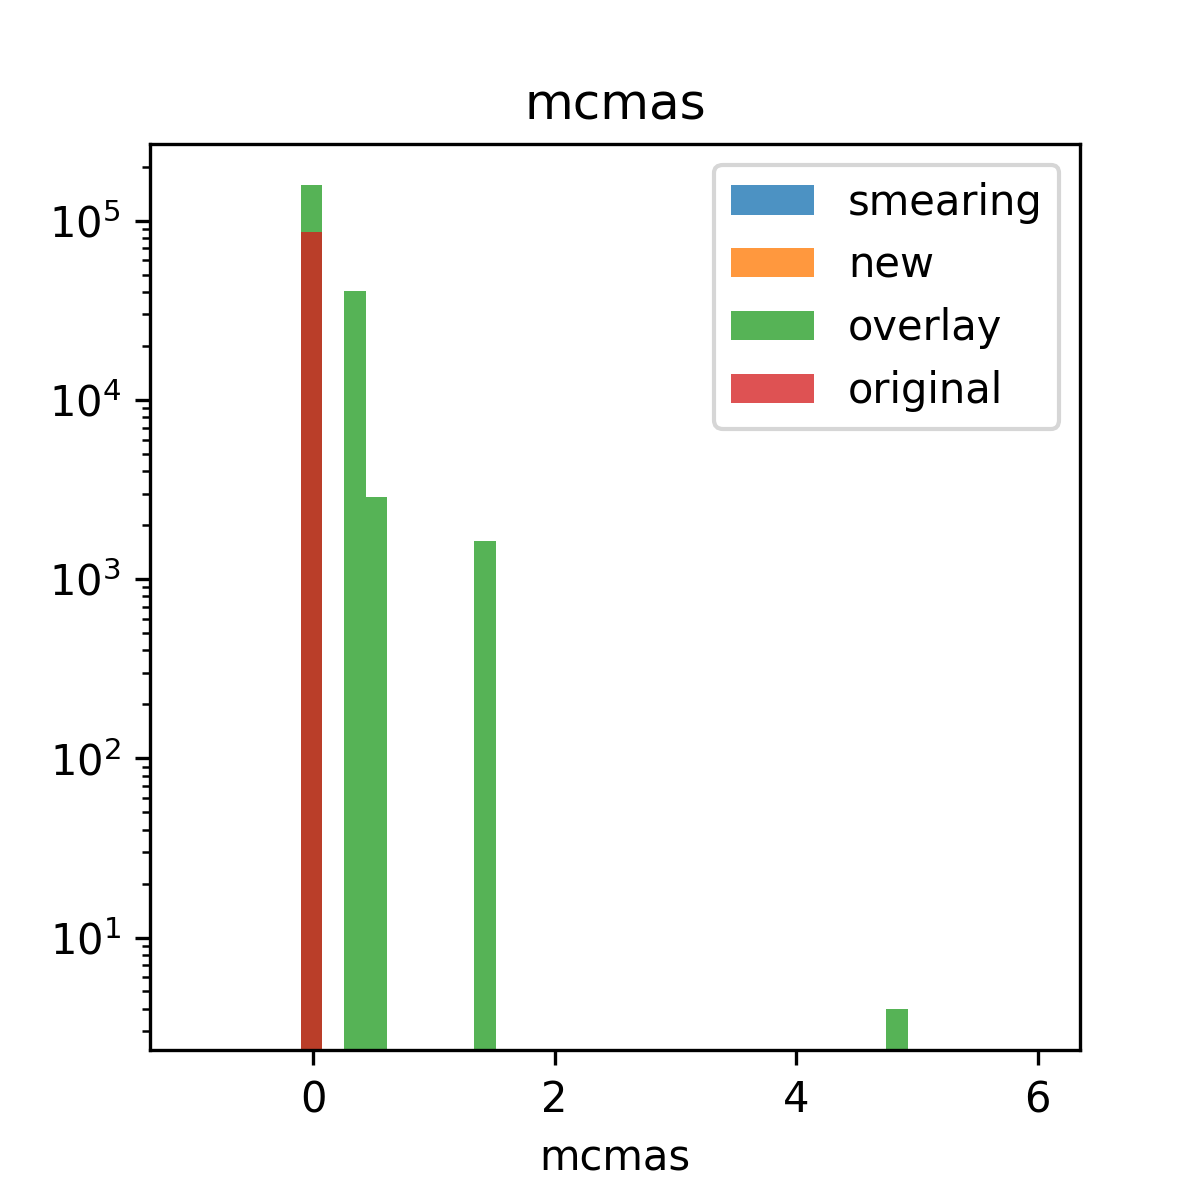

In [4]:
def show_smearing(var, bins=None):
    fig, ax = plt.subplots(figsize=(4, 4))
    c_0 = ak.flatten(getattr(x1, var) - getattr(x2, var))
    c_x = ak.flatten(getattr(mc, var))
    if bins is None:
        bins = np.linspace(
            min(ak.min(c_0), ak.min(c_x)),
            max(ak.max(c_0), ak.max(c_x)),
            100,
        )
    kw = dict(bins=bins, alpha=0.8)
    ax.hist(c_0, label="smearing", **kw)[1]
    ax.hist(ak.flatten(getattr(x2, var)), label="new", **kw)
    ax.hist(
        ak.flatten(getattr(mc, var)[(mc.mcgst == 3) & (mc.mcsst != -2147483648)]),
        label="overlay",
        **kw,
    )
    ax.hist(ak.flatten(getattr(x1, var)), label="original", **kw)
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel(var)
    ax.set_title(var)
    return (fig,)


@load_or_make(["show_smearing_mcmox"])
def show_smearing_mcmox():
    return show_smearing("mcmox")


show_smearing_mcmox()


@load_or_make(["show_smearing_mcmoy"])
def show_smearing_mcmoy():
    return show_smearing("mcmoy")


show_smearing_mcmoy()


@load_or_make(["show_smearing_mcmoz"])
def show_smearing_mcmoz():
    return show_smearing("mcmoz")


show_smearing_mcmoz()


@load_or_make(["show_smearing_mcene"])
def show_smearing_mcene():
    return show_smearing("mcene")


show_smearing_mcene()


@load_or_make(["show_smearing_mcmas"])
def show_smearing_mcmas():
    return show_smearing("mcmas", bins=np.linspace(-1, 6, 40))


show_smearing_mcmas();